In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from netcal.metrics import ECE

from utils_notebook import *

In [2]:
logits = torch.tensor(np.load('data_anytime_poe/ens_model_0_softmax_logits.npy'))
targets = torch.tensor(np.load('data_anytime_poe/ens_model_0_softmax_targets.npy'))

In [3]:
L = len(logits)

In [4]:
logits.shape

torch.Size([5, 10000, 10])

In [5]:
probs = torch.softmax(logits, dim=2)
probs_de = probs.cumsum(dim=0) / torch.tensor([1., 2., 3., 4., 5.])[:, None, None]
preds_de = {i: torch.argmax(probs_de, dim=2)[i, :] for i in range(L)}
acc_de = [(targets == preds_de[i]).sum() / len(targets) for i in range(L)]

In [13]:
acc_de

[tensor(0.8809),
 tensor(0.8871),
 tensor(0.8881),
 tensor(0.8898),
 tensor(0.8913)]

In [6]:
probs_ovr = ovr_likelihood(logits)
probs_poe_ovr = f_probs_ovr_poe(probs_ovr)
preds_poe_ovr = {i: torch.argmax(probs_poe_ovr, dim=2)[i, :] for i in range(L)}
acc_poe_ovr = [(targets == preds_poe_ovr[i]).sum() / len(targets) for i in range(L)]
ids_ood_poe_ovr = get_ood_ovr(probs_poe_ovr, L)
nr_ood_poe_ovr = {l: len(l_dict) for l, l_dict in ids_ood_poe_ovr.items()}

In [7]:
probs_poe_ovr_break_ties = f_probs_ovr_poe_break_ties(logits, probs_poe_ovr)
preds_poe_ovr_break_ties = {i: torch.argmax(probs_poe_ovr_break_ties, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties = [(targets == preds_poe_ovr_break_ties[i]).sum() / len(targets) for i in range(L)]

ids_ood_poe_ovr_break_ties = get_ood_ovr(probs_poe_ovr_break_ties, L)
nr_ood_poe_ovr_break_ties = {l: len(l_dict) for l, l_dict in ids_ood_poe_ovr_break_ties.items()}

In [12]:
acc_poe_ovr_break_ties

[tensor(0.8809),
 tensor(0.8868),
 tensor(0.8873),
 tensor(0.8891),
 tensor(0.8894)]

In [14]:
nr_ood_poe_ovr_break_ties

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}

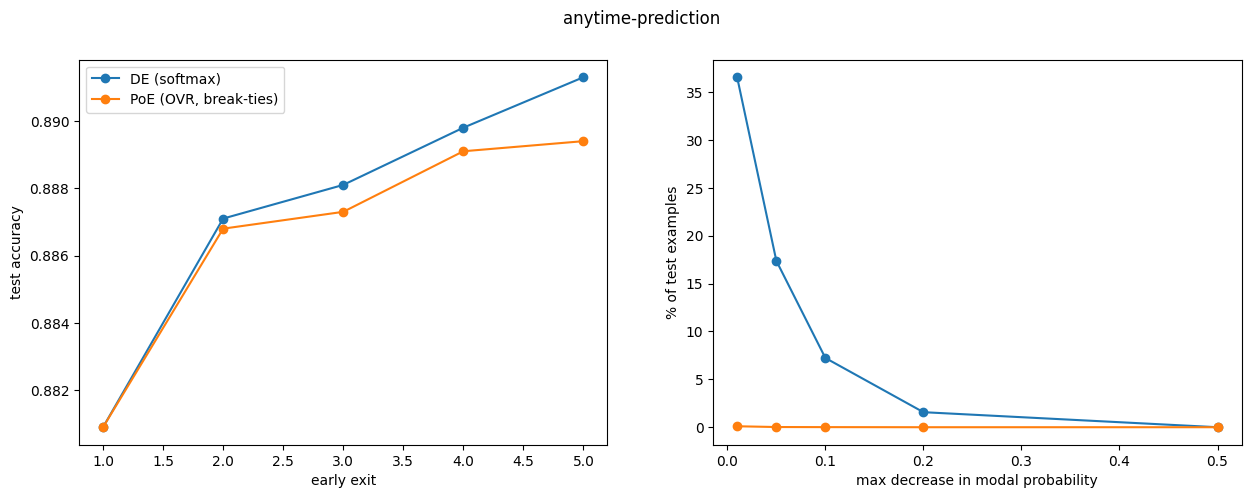

In [15]:
early_exits = [i + 1 for i in range(L)]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(early_exits, acc_de, label='DE (softmax)', marker='o')
# ax[0].plot(early_exits, acc_poe_ovr, label='PoE (OVR)', marker='o')
ax[0].plot(early_exits, acc_poe_ovr_break_ties, label='PoE (OVR, break-ties)', marker='o')
ax[0].legend()
# ax[0].set_title('anytime-prediction')
ax[0].set_ylabel('test accuracy')
ax[0].set_xlabel('early exit')

for _preds, _probs, label in [
                            (preds_de, probs_de, 'DE (softmax)'), 
                            # (preds_poe_ovr, probs_poe_ovr, 'PoE (OVR)'),
                            (preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, 'PoE (OVR, break-ties)'),]:
    modal_probs = modal_probs_decreasing(_preds, _probs, L)
    ax[1].plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)
# ax[1].legend()
# ax[1].set_title('anytime-prediction')
ax[1].set_xlabel('max decrease in modal probability')
ax[1].set_ylabel('% of test examples')


plt.suptitle('anytime-prediction')
plt.show()

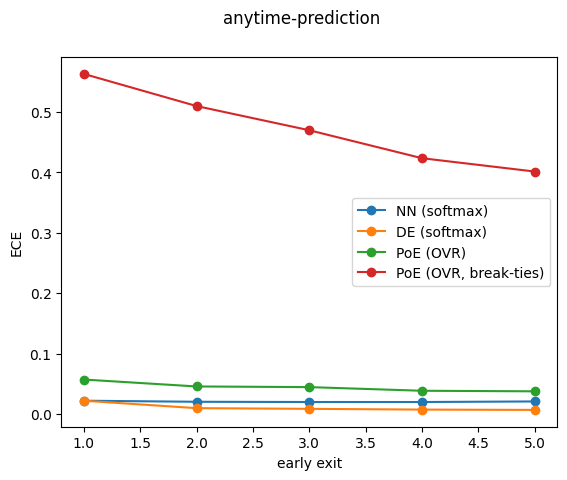

In [17]:
early_exits = [i + 1 for i in range(L)]
for _probs, label in [(probs, 'NN (softmax)'),  
                      (probs_de, 'DE (softmax)'), 
                      (probs_poe_ovr, 'PoE (OVR)'),
                      (probs_poe_ovr_break_ties, 'PoE (OVR, break-ties)'),]:
    ece = []
    for l in range(L):
        ece.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), targets.numpy()))
    plt.plot(early_exits, ece, marker='o', label=label)
plt.legend()
plt.xlabel('early exit')
plt.ylabel('ECE')

plt.suptitle('anytime-prediction')
plt.show()